In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Caricamento del Dataset
FILE_PATH = '../data/trajectories.csv'

# Leggiamo senza header perché il file contiene solo numeri
df = pd.read_csv(FILE_PATH, header=None, index_col=False)

print(f"Dimensione totale dataset: {df.shape}")

Dimensione totale dataset: (400400, 56)


In [7]:
def split_trajectories(df):
    """
    Spezza il dataframe in una lista di array numpy, uno per ogni traiettoria.
    Assume che la colonna 0 sia il tempo.
    """
    trajectories = []

    # Identifichiamo dove il tempo ricomincia da capo (o è 0)
    # Se il tempo al passo t è minore del tempo al passo t-1, è una nuova traiettoria
    time_col = df.iloc[:, 0].values
    # Troviamo gli indici dove inizia una nuova traiettoria
    split_indices = np.where(np.diff(time_col) < 0)[0] + 1

    # Splittiamo il dataframe in questi punti
    traj_list = np.split(df.values, split_indices)

    # Rimuoviamo la colonna del tempo (col 0) dalle feature per il training
    # Teniamo solo le 55 colonne fisiche
    clean_trajectories = [t[:, 1:] for t in traj_list]

    return clean_trajectories

# Eseguiamo lo split
all_trajectories = split_trajectories(df)
print(f"Trovate {len(all_trajectories)} traiettorie distinte.")
print(f"Shape di una traiettoria: {all_trajectories[0].shape}")

Trovate 400 traiettorie distinte.
Shape di una traiettoria: (1001, 55)


In [8]:
# Dividiamo le traiettorie in Train (80%) e Test (20%)
train_traj, test_traj = train_test_split(all_trajectories, test_size=0.2, random_state=42)

# Normalizzazione (MinMax tra 0 e 1 o -1 e 1 è standard per dati quantistici)
# Fittiamo lo scaler SOLO sul training set per correttezza metodologica
scaler = MinMaxScaler(feature_range=(-1, 1))

# Concateniamo temporaneamente per fittare lo scaler
train_concat = np.vstack(train_traj)
scaler.fit(train_concat)

# Applichiamo la trasformazione a ogni singola traiettoria
train_traj_norm = [scaler.transform(t) for t in train_traj]
test_traj_norm = [scaler.transform(t) for t in test_traj]

In [16]:
def create_dataset(trajectories, input_width, forecast_horizon=1):
    """
    Crea finestre scorrevoli (X, y).
    """
    X, y = [], []
    for t in trajectories:
        for i in range(len(t) - input_width - forecast_horizon + 1):
            X.append(t[i : i + input_width])
            y.append(t[i + input_width : i + input_width + forecast_horizon])
    return np.array(X), np.array(y)

In [17]:
class QuantumRNN(Model):
    def __init__(self, hidden_units, output_dim, dropout_rate=0.2):
        super(QuantumRNN, self).__init__()

        # Layer di Normalizzazione
        self.norm = layers.LayerNormalization()

        # GRU 1: return_sequences=True per passare la sequenza alla seconda GRU
        # Aggiungiamo dropout e recurrent_dropout per regolarizzazione
        self.gru1 = layers.GRU(
            hidden_units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )

        # GRU 2: Elabora la sequenza e restituisce solo l'ultimo stato
        self.gru2 = layers.GRU(
            hidden_units,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )

        # Dense Layer finale per la regressione (56 parametri)
        self.dense_out = layers.Dense(output_dim)

    def call(self, inputs, training=False):
        # Il parametro 'training' gestisce automaticamente il dropout:
        # viene attivato solo durante fit/train e disattivato durante l'esame (inferenza)
        x = self.norm(inputs)
        x = self.gru1(x, training=training)
        x = self.gru2(x, training=training)
        return self.dense_out(x)

In [15]:

from tensorflow.keras import layers, Model

# --- A. BLOCCO TRANSFORMER (Singolo strato ripetibile) ---
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # 1. Multi-Head Attention
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # 2. Feed Forward Network
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])

        # 3. Normalizzazione e Dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Attention + Residual Connection + Norm
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed Forward + Residual Connection + Norm
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# --- B. MODELLO COMPLETO (Transformer per Time Series) ---
class QuantumTransformer(Model):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, output_dim, input_seq_len, dropout_rate=0.1):
        super(QuantumTransformer, self).__init__()

        # Proiezione dell'input (Feature 55 -> embed_dim)
        self.input_embedding = layers.Dense(embed_dim)

        # Positional Encoding (Imparabile)
        # Creiamo un vettore di pesi che rappresenta la posizione temporale
        self.pos_encoding = self.add_weight(
            name="pos_enc",
            shape=(1, input_seq_len, embed_dim),
            initializer="zeros",
            trainable=True
        )

        # Stack di Transformer Blocks
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)
            for _ in range(num_layers)
        ]

        # Pooling e Output
        self.global_avg_pooling = layers.GlobalAveragePooling1D()
        self.dropout_final = layers.Dropout(dropout_rate)
        self.dense_out = layers.Dense(output_dim)

    def call(self, inputs, training=False):
        # 1. Embedding + Posizione
        x = self.input_embedding(inputs)
        x = x + self.pos_encoding # Somma element-wise

        # 2. Passaggio nei blocchi
        for block in self.transformer_blocks:
            x = block(x, training=training)

        # 3. Output Head
        x = self.global_avg_pooling(x)
        x = self.dropout_final(x, training=training)
        return self.dense_out(x)

In [ ]:
def get_dataset_for_config(window_size, batch_size):
    """Genera il dataset in base alla finestra temporale della config"""
    # Creazione numpy
    X_tr, y_tr = create_dataset(train_traj_norm, input_width=window_size)
    X_te, y_te = create_dataset(test_traj_norm, input_width=window_size)

    # Squeeze target
    y_tr = y_tr.squeeze(1)
    y_te = y_te.squeeze(1)

    # Creazione tf.data
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
    train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices((X_te, y_te)).batch(batch_size)
    return train_ds, test_ds, X_te, y_te

# Funzioni di Augmentation
def apply_masking(x, prob=0.15):
    mask = tf.random.uniform(shape=tf.shape(x)) > prob
    return x * tf.cast(mask, dtype=x.dtype)

def apply_noise(x, stddev=0.05):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype)
    return x + noise

In [36]:
HYPERPARAMETERS_LIST = [
    {
        "name": "Config_A (Small)",
        "window_size": 10,
        "units": 32,
        "dropout": 0.1,
        "learning_rate": 0.01,
        "batch_size": 64
    },
    {
        "name": "Config_B (Medium - Standard)",
        "window_size": 10,
        "units": 64,
        "dropout": 0.2,
        "learning_rate": 0.001,
        "batch_size": 64
    },
    {
        "name": "Config_C (Large - Long Memory)",
        "window_size": 20,
        "units": 128,
        "dropout": 0.3,
        "learning_rate": 0.0005,
        "batch_size": 128
    }
]

In [18]:
from tqdm import tqdm
import tensorflow as tf

# --- 3. FUNZIONE DI TRAINING SINGOLO ---
def run_experiment(config):
    print(f"\n--- Inizio Training: {config['name']} ---")

    # 1. Preparazione Dati
    train_ds, test_ds, _, _ = get_dataset_for_config(config['window_size'], config['batch_size'])

    # 2. Creazione Modello
    model = QuantumRNN(hidden_units=config['units'], output_dim=55, dropout_rate=config['dropout'])

    # 3. Setup Training
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Metriche (le ricreiamo per ogni esperimento per azzerarle)
    train_loss_metric = tf.keras.metrics.Mean()
    test_loss_metric = tf.keras.metrics.Mean()
    train_mae_metric = tf.keras.metrics.MeanAbsoluteError()

    # Steps compilati con tf.function (definiti internamente per catturare optimizer e model nuovi)
    @tf.function
    def train_step(x, y, phase):
        if phase == "masking": x = apply_masking(x)
        elif phase == "noise": x = apply_noise(x)

        with tf.GradientTape() as tape:
            preds = model(x, training=True)
            loss = loss_fn(y, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_loss_metric.update_state(loss)
        train_mae_metric.update_state(y, preds)
        return loss

    @tf.function
    def test_step(x, y):
        preds = model(x, training=False)
        loss = loss_fn(y, preds)
        test_loss_metric.update_state(loss)

    # 4. Loop Epoche
    history = {'loss': [], 'val_loss': [], 'mae': []}
    EPOCHS = 30

    for epoch in range(EPOCHS):
        # Logica Fasi
        if epoch < 10: phase, desc = "standard", "Standard"
        elif epoch < 20: phase, desc = "masking", "Masking"
        else: phase, desc = "noise", "Noise"

        # Reset metriche
        train_loss_metric.reset_state()
        test_loss_metric.reset_state()
        train_mae_metric.reset_state()

        # Train Loop
        with tqdm(total=len(train_ds), desc=f"Ep {epoch+1}/{EPOCHS} [{config['name']}-{desc}]", unit="bt", leave=False) as pbar:
            for x_b, y_b in train_ds:
                l = train_step(x_b, y_b, phase)
                pbar.set_postfix({'loss': f'{l:.4f}'})
                pbar.update(1)

        # Validation Loop
        for x_te, y_te in test_ds:
            test_step(x_te, y_te)

        # Salvataggio
        history['loss'].append(train_loss_metric.result().numpy())
        history['val_loss'].append(test_loss_metric.result().numpy())
        history['mae'].append(train_mae_metric.result().numpy())

    print(f"Fine. Val Loss Finale: {history['val_loss'][-1]:.5f}")
    return history, model

# --- 4. ESECUZIONE DI TUTTE LE CONFIGURAZIONI ---
import os
import gc # Garbage collector per la memoria

results = {}
best_val_loss = float('inf')
best_config_name = ""

# Creiamo la cartella una volta sola all'inizio
os.makedirs('../models', exist_ok=True)

for config in HYPERPARAMETERS_LIST:
    print(f"\nPulizia memoria prima di {config['name']}...")
    # Pulisce la memoria della sessione Keras/TensorFlow
    tf.keras.backend.clear_session()
    # Forza Python a liberare la RAM inutilizzata (Cruciale per Config C)
    gc.collect()

    # --- ESECUZIONE ---
    # Esegue l'esperimento
    hist, trained_model = run_experiment(config)

    # Salva la storia per i grafici
    results[config['name']] = hist

    # --- SALVATAGGIO IMMEDIATO (SAFE MODE) ---
    # Creiamo un nome file unico per questa configurazione
    # Es: rnn_Config_A_(Small).weights.h5
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    file_name = f"../models/rnn_{safe_name}.weights.h5"

    try:
        trained_model.save_weights(file_name)
        print(f"SALVATO: {file_name}")
    except Exception as e:
        print(f"Errore salvataggio {config['name']}: {e}")

    # --- TRACKING DEL MIGLIORE ---
    final_val_loss = hist['val_loss'][-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_config_name = config['name']

# --- RIEPILOGO FINALE ---
print(f"\n{'='*40}")
print(f"MIGLIOR RNN: {best_config_name}")
print(f"Best Val Loss: {best_val_loss:.5f}")
print(f"{'='*40}")


Pulizia memoria prima di Config_A (Small)...

--- Inizio Training: Config_A (Small) ---


KeyboardInterrupt: 

In [ ]:
TRANSFORMER_CONFIGS = [
    {
        "name": "Transf_A (Small)",
        "window_size": 10,
        "embed_dim": 32,      # Dimensione interna (simile a units)
        "num_heads": 2,       # Quante "teste" guardano i dati
        "ff_dim": 32,         # Dimensione rete interna al blocco
        "num_layers": 1,      # Solo 1 blocco (leggero)
        "dropout": 0.1,
        "learning_rate": 0.001,
        "batch_size": 64
    },
    {
        "name": "Transf_B (Medium)",
        "window_size": 10,
        "embed_dim": 64,
        "num_heads": 4,       # Più attenzione ai dettagli
        "ff_dim": 64,
        "num_layers": 2,      # 2 Blocchi sovrapposti
        "dropout": 0.2,
        "learning_rate": 0.0005, # LR più basso per stabilità
        "batch_size": 64
    },
    {
        "name": "Transf_C (Large - Deep)",
        "window_size": 20,    # Finestra più lunga
        "embed_dim": 128,
        "num_heads": 4,
        "ff_dim": 128,
        "num_layers": 3,      # 3 Blocchi (Modello profondo)
        "dropout": 0.3,
        "learning_rate": 0.0001,
        "batch_size": 128
    }
]

In [19]:
import gc

def run_transformer_experiment(config):
    print(f"\n--- Inizio Training Transformer: {config['name']} ---")

    # 1. Preparazione Dati (Identica a prima)
    train_ds, test_ds, _, _ = get_dataset_for_config(config['window_size'], config['batch_size'])

    # 2. Creazione Modello (MODIFICATO PER TRANSFORMER)
    model = QuantumTransformer(
        num_layers=config['num_layers'],
        embed_dim=config['embed_dim'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        output_dim=55,           # Feature del dataset
        input_seq_len=config['window_size'], # Necessario per Positional Encoding
        dropout_rate=config['dropout']
    )

    # Inizializzazione pesi (dummy pass necessario per subclassing)
    dummy_x = tf.random.uniform((1, config['window_size'], 55))
    _ = model(dummy_x)

    # 3. Setup Training (Identico a prima)
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    train_loss_metric = tf.keras.metrics.Mean()
    test_loss_metric = tf.keras.metrics.Mean()
    train_mae_metric = tf.keras.metrics.MeanAbsoluteError()

    # Steps compilati
    @tf.function
    def train_step(x, y, phase):
        if phase == "masking": x = apply_masking(x)
        elif phase == "noise": x = apply_noise(x)

        with tf.GradientTape() as tape:
            preds = model(x, training=True)
            loss = loss_fn(y, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_loss_metric.update_state(loss)
        train_mae_metric.update_state(y, preds)
        return loss

    @tf.function
    def test_step(x, y):
        preds = model(x, training=False)
        loss = loss_fn(y, preds)
        test_loss_metric.update_state(loss)

    # 4. Loop Epoche (Identico a prima)
    history = {'loss': [], 'val_loss': [], 'mae': []}
    EPOCHS = 30

    for epoch in range(EPOCHS):
        if epoch < 10: phase, desc = "standard", "Standard"
        elif epoch < 20: phase, desc = "masking", "Masking"
        else: phase, desc = "noise", "Noise"

        train_loss_metric.reset_state()
        test_loss_metric.reset_state()
        train_mae_metric.reset_state()

        with tqdm(total=len(train_ds), desc=f"Ep {epoch+1}/{EPOCHS} [{config['name']}-{desc}]", unit="bt", leave=False) as pbar:
            for x_b, y_b in train_ds:
                l = train_step(x_b, y_b, phase)
                pbar.set_postfix({'loss': f'{l:.4f}'})
                pbar.update(1)

        for x_te, y_te in test_ds:
            test_step(x_te, y_te)

        history['loss'].append(train_loss_metric.result().numpy())
        history['val_loss'].append(test_loss_metric.result().numpy())
        history['mae'].append(train_mae_metric.result().numpy())

    print(f"Fine. Val Loss Finale: {history['val_loss'][-1]:.5f}")
    return history, model

# --- 5. ESECUZIONE MAIN LOOP (TRANSFORMER) ---
results_transf = {}
best_val_loss_transf = float('inf')
best_config_name_transf = ""

os.makedirs('../models', exist_ok=True)

for config in TRANSFORMER_CONFIGS:
    print(f"\nPulizia memoria prima di {config['name']}...")
    tf.keras.backend.clear_session()
    gc.collect()

    # Esecuzione
    hist, trained_model = run_transformer_experiment(config)
    results_transf[config['name']] = hist

    # Salvataggio
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    file_name = f"../models/transf_{safe_name}.weights.h5"

    try:
        trained_model.save_weights(file_name)
        print(f"SALVATO: {file_name}")
    except Exception as e:
        print(f"Errore salvataggio {config['name']}: {e}")

    # Tracking Best
    final_val_loss = hist['val_loss'][-1]
    if final_val_loss < best_val_loss_transf:
        best_val_loss_transf = final_val_loss
        best_config_name_transf = config['name']

print(f"\n{'='*40}")
print(f"MIGLIOR TRANSFORMER: {best_config_name_transf}")
print(f"Best Val Loss: {best_val_loss_transf:.5f}")
print(f"{'='*40}")


Pulizia memoria prima di Transf_A (Small)...

--- Inizio Training Transformer: Transf_A (Small) ---


Ep 30/30 [Transf_C (Large - Deep)-Noise]:  86%|████████▌ | 2098/2453 [06:11<01:01,  5.76bt/s, loss=0.0091]7]]

In [39]:
# --- 5. RICARICAMENTO DEL MODELLO VINCITORE ---
best_config_name = 'Config_B (Medium - Standard)'

# 1. Recuperiamo la configurazione (iperparametri) del vincitore
best_conf = next(conf for conf in HYPERPARAMETERS_LIST if conf['name'] == best_config_name)

# 2. Ricostruiamo l'architettura del modello (vuota)
# Usiamo gli stessi parametri definiti nella config vincente
best_model = QuantumRNN(
    hidden_units=best_conf['units'],
    output_dim=55,
    dropout_rate=best_conf['dropout']
)

# 3. Inizializziamo i pesi con un input finto (Necessario per il Subclassing)
# Questo dice a TensorFlow che forma hanno i dati
dummy_input = tf.random.uniform((1, best_conf['window_size'], 55))
_ = best_model(dummy_input)

# 4. Carichiamo i pesi dal file .h5 che abbiamo salvato durante il loop
safe_name = best_config_name.replace(" ", "_").replace("(", "").replace(")", "")
file_name = f"../models/rnn_{safe_name}.weights.h5"

try:
    best_model.load_weights(file_name)
    print(f"Pesi caricati con successo da: {file_name}")
except Exception as e:
    print(f"Errore critico nel caricamento pesi: {e}")


Pesi caricati con successo da: ../models/rnn_Config_B_Medium_-_Standard.weights.h5


In [30]:
# --- 6. RICARICAMENTO DEL MIGLIOR TRANSFORMER ---

print(f"\n{'='*40}")
print(f"RECUPERO DEL MIGLIOR TRANSFORMER: {best_config_name_transf}")
print(f"{'='*40}")

# 1. Recuperiamo la configurazione vincente
# Nota: usiamo best_config_name_transf che abbiamo tracciato nel loop precedente
best_conf_transf = next(conf for conf in TRANSFORMER_CONFIGS if conf['name'] == best_config_name_transf)

# 2. Ricostruiamo l'architettura del modello
best_transformer = QuantumTransformer(
    num_layers=best_conf_transf['num_layers'],
    embed_dim=best_conf_transf['embed_dim'],
    num_heads=best_conf_transf['num_heads'],
    ff_dim=best_conf_transf['ff_dim'],
    output_dim=55,
    input_seq_len=best_conf_transf['window_size'],
    dropout_rate=best_conf_transf['dropout']
)

# 3. Inizializziamo i pesi con un input finto
dummy_input = tf.random.uniform((1, best_conf_transf['window_size'], 55))
_ = best_transformer(dummy_input)

# 4. Carichiamo i pesi dal file
safe_name = best_config_name_transf.replace(" ", "_").replace("(", "").replace(")", "")
file_name = f"../models/transf_{safe_name}.weights.h5"

try:
    best_transformer.load_weights(file_name)
    print(f"✅ Pesi Transformer caricati da: {file_name}")
except Exception as e:
    print(f"❌ Errore critico caricamento Transformer: {e}")


RECUPERO DEL MIGLIOR TRANSFORMER: Transf_B (Medium)
✅ Pesi Transformer caricati da: ../models/transf_Transf_B_Medium.weights.h5


In [33]:
# GRAFICI
plt.style.use('seaborn-v0_8-whitegrid')

def plot_training_phases_detailed(history, config_name, filename):
    """
    Plotta Loss e MAE con linee verticali allineate perfettamente alle epoche 10 e 20.
    """
    epochs = range(1, len(history['loss']) + 1)

    # Creiamo una figura con 2 grafici affiancati
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # --- GRAFICO 1: LOSS (MSE) ---
    ax1.plot(epochs, history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
    ax1.plot(epochs, history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2)

    # Calcolo posizione testo
    y_min, y_max = ax1.get_ylim()
    text_y_pos = y_max - (y_max - y_min) * 0.05

    # --- MODIFICA QUI: Linee verticali su interi esatti ---

    # Fase 1: Standard (Testo centrato su epoca 5)
    ax1.text(5, text_y_pos, 'FASE 1:\nSTANDARD', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    # Linea su Epoca 10 (Fine Standard / Inizio Masking)
    ax1.axvline(x=10, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

    # Fase 2: Masking (Testo centrato su epoca 15)
    ax1.text(15, text_y_pos, 'FASE 2:\nMASKING', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    # Linea su Epoca 20 (Fine Masking / Inizio Noise)
    ax1.axvline(x=20, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

    # Fase 3: Noise (Testo centrato su epoca 25)
    ax1.text(25, text_y_pos, 'FASE 3:\nNOISE', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    ax1.set_title(f'Training Dynamics - {config_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoche')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc='lower left')
    ax1.grid(True, alpha=0.3)

    # Impostiamo i tick dell'asse X per mostrare i numeri chiave
    # Questo forza il grafico a mostrare 1, 10, 20, 30 sull'asse
    ax1.set_xticks([1, 5, 10, 15, 20, 25, 30])

    # --- GRAFICO 2: MAE ---
    ax2.plot(epochs, history['mae'], label='Train MAE', color='#2ca02c', linewidth=2)

    # Linee verticali anche qui (esattamente su 10 e 20)
    ax2.axvline(x=10, color='red', linestyle='--', alpha=0.5)
    ax2.axvline(x=20, color='red', linestyle='--', alpha=0.5)

    ax2.set_title('Mean Absolute Error Evolution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoche')
    ax2.set_ylabel('MAE')
    ax2.set_xticks([1, 5, 10, 15, 20, 25, 30]) # Forza i tick anche qui
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("../plots/" + filename, dpi=300)
    plt.show()

def plot_trajectory_check(model, trajectories_list, window_size, config_name, filename="best_predictions_check.png"):
    """
    Confronto Predizione vs Realtà su una traiettoria di test.
    """
    # Prendiamo una traiettoria di test a caso (es. indice 0)
    traj_idx = 3
    if len(trajectories_list) > 0:
        real_traj = trajectories_list[traj_idx]

        # Creazione input sequenziale
        X_seq, y_seq = [], []
        for i in range(len(real_traj) - window_size):
            X_seq.append(real_traj[i : i + window_size])
            y_seq.append(real_traj[i + window_size])

        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)

        # Predizione
        print("Generazione predizioni per il grafico...")
        y_pred = model.predict(X_seq, batch_size=32, verbose=0)

        # Plot
        plt.figure(figsize=(14, 6))
        feature_idx = 0 # Magnetizzazione Z (Feature più importante)

        plt.plot(y_seq[:, feature_idx], label='Realtà (Ground Truth)', color='black', alpha=0.7, linewidth=2)
        plt.plot(y_pred[:, feature_idx], label=f'Predizione ({config_name})', color='#d62728', linestyle='--', linewidth=1.5)

        plt.title(f'Verifica Traiettoria: {config_name} (Window: {window_size})', fontsize=14, fontweight='bold')
        plt.xlabel('Time Steps')
        plt.ylabel('Valore Normalizzato')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(filename, dpi=300)
        plt.show()
    else:
        print("Errore: Lista traiettorie vuota.")


Storia del training non trovata.
Generazione predizioni per il grafico...


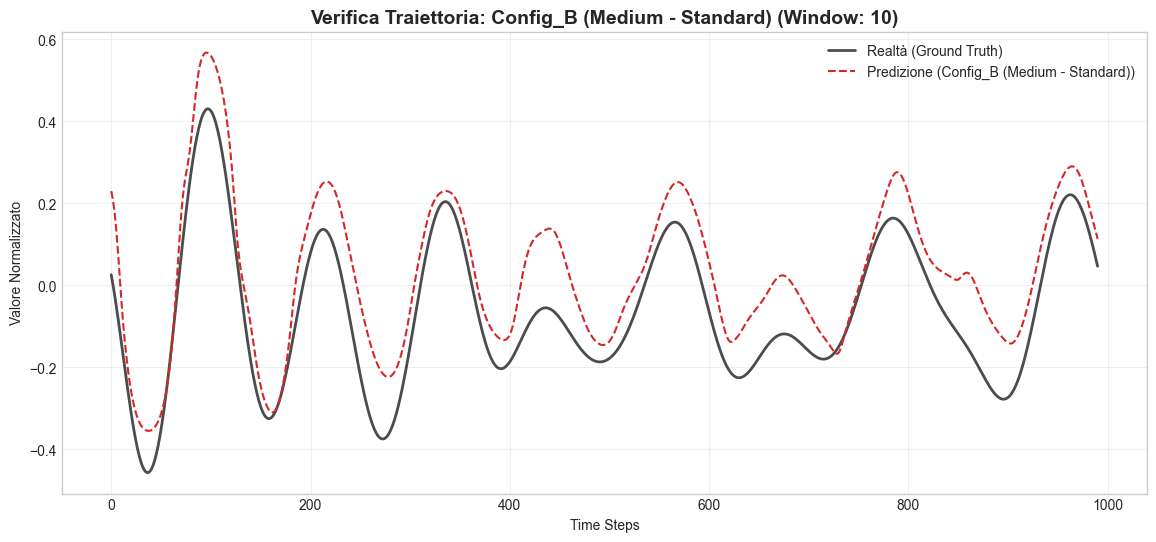

In [40]:
# --- ESECUZIONE GRAFICI RNN ---

# 1. Grafico Fasi Training (usando la history salvata nel dizionario results)
if best_config_name in results:
    print(f"Generazione grafico Fasi per: {best_config_name}")
    plot_training_phases_detailed(
        results[best_config_name],
        best_config_name,
        filename="best_rnn_training.png"
    )
else:
    print("Storia del training non trovata.")

# 2. Grafico Predizione (usando il best_model ricaricato)
if 'test_traj_norm' in globals() and 'best_model' in globals():
    # Recuperiamo la window size vincente
    win_size = next(conf['window_size'] for conf in HYPERPARAMETERS_LIST if conf['name'] == best_config_name)

    plot_trajectory_check(
        best_model,
        test_traj_norm,
        window_size=win_size,
        config_name=best_config_name,
        filename="../plots/best_rnn_prediction.png"
    )
else:
    print("Variabili necessarie per i grafici non trovate. Assicurati che il training sia finito.")

Generazione grafico Fasi per: Transf_B (Medium)


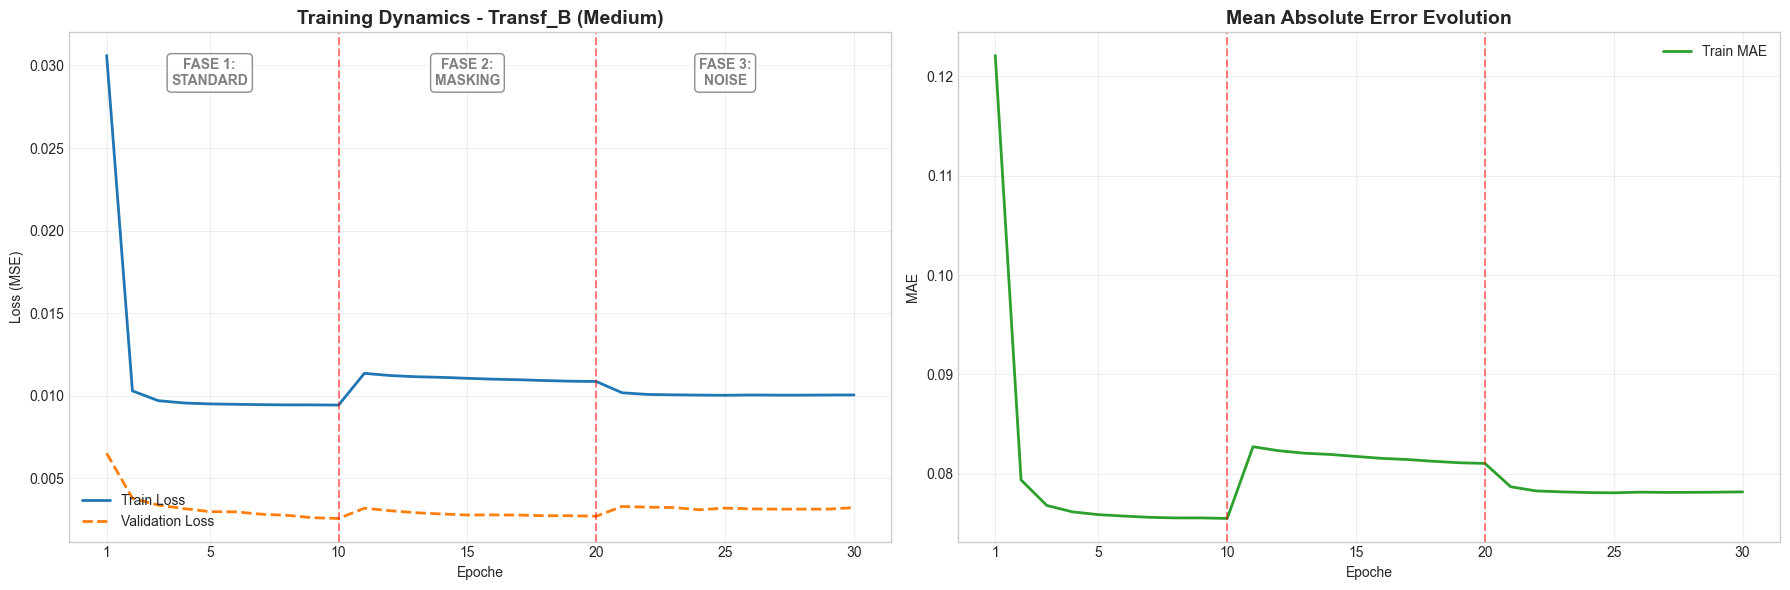

Generazione predizioni per il grafico...


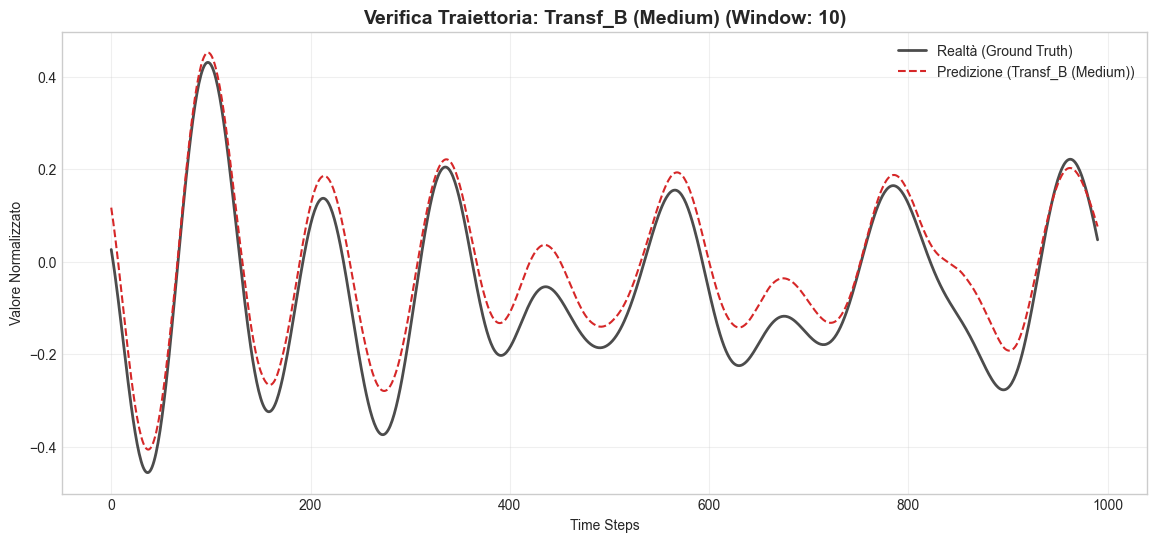

In [34]:
# --- ESECUZIONE GRAFICI TRANSFORMER ---
if best_config_name_transf in results_transf:
    print(f"Generazione grafico Fasi per: {best_config_name_transf}")
    plot_training_phases_detailed(
        results_transf[best_config_name_transf],
        best_config_name_transf,
        filename="best_transformer_training.png"
    )
else:
    print("Storia del training Transformer non trovata.")

# 2. Grafico Predizione
if 'test_traj_norm' in globals() and 'best_transformer' in globals():
    plot_trajectory_check(
        best_transformer,
        test_traj_norm,
        window_size=best_conf_transf['window_size'],
        config_name=best_config_name_transf,
        filename="../plots/best_transformer_prediction.png"
    )
else:
    print("Impossibile generare i grafici: mancano i dati o il modello.")